These past few weeks, I've been powering through PyTorch notebooks and tutorials, mostly because I enjoyed the PyTorch API so much and found so many of it useful and intuitive. Well, the problem was that I ended up writing something like ten notebooks without ever publishing them on this blog. So really, I'm going over some old notebooks I've coded out more than a month ago to finally make it live. 

That's enough excuses, let's get into the basics of PyTorch modeling in this notebook with the CIFAR10 dataset and some basic CNNs. 

# Setup

The setup is pretty simple here. We import some modules and functions from PyTorch, as well as `matplotlib` to be able to show some basic training plots. 

One thing I have noticed is that a lot of people do something like 

```python
import torch.nn as nn
```

which I personally don't really get, because you can easily just do

```python
from torch import nn
```

If you ask me, I think the latter is more elegant and less cluttered (after all, we don't have to repeat `nn` twice). I don't think the two import statements are functionally different, but if I do figure out any differences, I will make sure to update future notebooks. 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Device Configuration

One of the many nice things about PyTorch is the clean, intuitive API. PyTorch comes with good GPU support, and one of the main ways through which this can be done is by creating a `device` object. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Because I am running this notebook on my MacBook Pro, which obviously does not come with Nvidia cuda-enabled graphics cards, the device is set as the CPU. Now, I can "move" tensors and models up to the GPU by doing something like

```pytorch
model.to(device)
tensor.to(device)
```

and these statements would allow inference and training to occur within the GPU.

## Constants

And below are some constants I will be using in this notebook. Namely, we will run training for a total of 4 epochs, with a batch size of 32 and a learning rate of 0.001. 

In [3]:
num_epochs = 4
batch_size = 32
learning_rate = 0.001

Now that we have all the things we need, let's jump into some data preparation and modeling. 

# Data Preparation

Another thing I love about PyTorch is the sheer ease with which you can preprocess data. 

## Transforms

PyTorch makes it incredibly easy to combine and stack multiple transforms to create custom transformations to be applied to the dataset. The easiest way to go about this is to use the `transforms.Compose()` method, which looks like this:

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Here, we are applying to transformations: the first changes the dataset and casts it into PyTorch tensors,, and the second one normalizes the dataset to have a mean of 0.5 and a standard deviation of also 0.5 across all three channels of RGB. 

How can we apply this transform? Well, we can pass it to initialize the datasets as shown below:

In [5]:
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


Because I already have the CIFAR10 downloaded in the `./data` directory of my local, PyTorch does not download the dataset again. 

## Dataloader

We could go with the dataset as-is, but we can use the `Dataloader` class to further batch and shuffle the dataset, which we normally want 99 percent of the time. This is as simple as calling `Dataloader` and passing in the dataset we want to load.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

If we loop through the `train_loader`, for instance, we can see that it is giving us a nice batch of 32 photos. Note that the dimensions are in the form of `(batch_size, num_channels, height, width)`. As for the labels, we get 32 values where each number corresponds to an image.

In [8]:
for i, (image, label) in enumerate(train_loader):
    print(image.shape)
    print(label.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


As the last step, let's just make sure that we know what each of these labels correspond to. The `classes` is a tuple of strings that translate label indices to actual strings we can interpret. For example, if we see the label `0`, we know that it denotes `classes[0]`, which is `"plane"`. 

In [7]:
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

# Modeling

Modeling in PyTorch is the probably the part I love the most. TensorFlow's sequential API is a great way to start, and PyTorch also provides the same sort of way of building sequential models. However, once you try to build anything that's more complicated than that, I think PyTorch's class-based way of approaching modeling makes a lot more intuitive sense and provides more room for experimentation and customization. 

Before getting into too much detail, below is a very simple CNN we will refer to as an example throughout this post.

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Initialization

The first thing you will realize is that the model itself is a class that inherits from `nn.Module`. This is a pattern you will see all the time with PyTorch models. `nn.Modules` is a super class from which we can inherit to build anything from full-fledged models to custom blocks or layers to be used in some other larger model. 

In the initialization function, we also define a number of layers that will be used in forward propagation. You might be wondering why these have to initialized in the initialization function, as opposed to the forward function itself. While I don't have a complete, technically cogent explanation to that question, intuitively, we can understand a model's layers as being components of the model itself. After all, the weights of these layers are adjusted with each iteration or epoch. In that sense, we want the layers to be attached to the model instance itself; hence the OOP design of PyTorch's model class.

In this particular instance, we define a number of convolutional layers, a pooling layer, and two fully connected layers used for classification output. The declaration of the layers themselves are not too different from other frameworks, such as TensorFlow. Also, I've written out all the named arguments so that it is immediately clear what each argument is configuring. 

## Forward 

Once we've declared all the necessary components in the initialization function, the next steps to actually churn out forward propagation results given some input. In PyTorch, this is done by defining the `forward()` function. 

As you can see above, we basically call on the layers we've declared in the initialization function via `self.layer` and pass in any parameters we want. Since this is a very simple CNN, you will see that there is nothing exciting going on; we are simply getting the output of the previous layer and passing that as input into the next. After going through some convolutions and fully connected layers, we can return the result. 

### Functionals

There are one caveats worth mentioning here, which is the use of `F.relu()`. There is a `nn.Relu()` that I could have easily used, and indeed there is an entire discussion on the [PyTorch forum](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-vs-f-relu/27599) on the difference between the two. The bottom line is that they are pretty similar for our purposes. The most salient difference between the two is that the functional approach cannot be used when declaring a sequential model. However, since we are defining a custom forward function, this limitation does not apply. Personally, I prefer the functional because it means that there is one less layer to declare in the initialization function. However, it's probably better to err on the side of the `nn.Relu()` if you're not totally sure. 

# Training

Now that we've designed and implemented a model, it's time to train it. 

This is the part where people might argue that TensorFlow 2 or Keras is superior to PyTorch. In Keras, you can simply call `model.fit()` to train the model. However, in PyTorch, this is not necessarily the case, unless you really want to imitate the Keras API and define a `self.fit()` function yourself. PyTorch is more low-level in that you need to define a custom training loop manually. 

However, I actually prefer this low-levelness because it requires me to really think through what is happening in each iteration, namely what the dimension of each batch is, what the model expects to receive as input in the forward computation, and what loss function is appropriate given the output and label. Let's see what all of this means.

First, we begin by actually initializing an instance of the model, a loss function named `criterion`, and an `optimizer`, which is Adam in this case.

In [10]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Cross Entropy

A quick note of caution: if you dig into the PyTorch documentation or look at other example classifiers, you will realize, like me, there are two loss functions you can typically use: `nn.CrossEntropyLoss()` and `nn.NLLLoss()`, or negative log likelihood loss. The difference between the former and latter is that, while the former applies a softmax function to the output before calculating the actual loss, the latter does not. In our case, since we simply output the raw logits instead of applying a softmax calculation, we need to use the former. 

Let's return where we were. Before we jump into training and defining the training loop, it's always a good idea to see if the output of the model is what you'd expect. In this case, we can simply define some random dummy input and see if the output is correct. 

In [11]:
x = torch.randn(64, 3, 32, 32)
print(model(x).shape)

torch.Size([64, 10])


Now that we've verified the input and output dimensions, we can move onto defining the training loop.

## Training Loop

Defining the training loop may seem difficult at first, especially if you're coming from a Keras background, but actually a lot of it is boiler plate, and things are not as difficult as they may seem. 

First, we define a list to hold the loss values per iteration. We will be using this list for visualization later. 

The exciting part comes next. For each epoch, we load the images in the `train_loader`. Note that the loader returns a tuple of images and labels, which we can unpack directly within the `for` loop itself. We then move the two objects to `device`, which would be necessary if we were running this one a Cuda-enabled computer. Then, we calculate the loss by calling `criterion`, the loss function, and append the loss to the `loss_history` list. Note that we have to call `loss.item()` since `loss` itself is a one-by-one PyTorch tensor. 

In [12]:
loss_history = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 500 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Batch [{i + 1}/{len(train_loader)}], "
                f"Loss: {loss.item():.4f}"
            )

Epoch [1/4], Batch [500/1563], Loss: 1.2798
Epoch [1/4], Batch [1000/1563], Loss: 1.1682
Epoch [1/4], Batch [1500/1563], Loss: 1.3911
Epoch [2/4], Batch [500/1563], Loss: 1.0510
Epoch [2/4], Batch [1000/1563], Loss: 0.9175
Epoch [2/4], Batch [1500/1563], Loss: 1.1130
Epoch [3/4], Batch [500/1563], Loss: 0.9330
Epoch [3/4], Batch [1000/1563], Loss: 0.6095
Epoch [3/4], Batch [1500/1563], Loss: 0.7042
Epoch [4/4], Batch [500/1563], Loss: 0.7850
Epoch [4/4], Batch [1000/1563], Loss: 0.5785
Epoch [4/4], Batch [1500/1563], Loss: 0.9072


Then comes the important part where we perform backprop. The idea is that we would

* clear the previous gradient values, if any
* calculate the gradient for the current iteration
* apply the gradient to adjust weights

The three steps correspond to each of the lines in the code above, starting from `optimizer.zero_grad()`. As you might be able to guess from the name of the function, we zero the gradients to make sure that we aren't accumulating gradient values from one iteration to the next. Calling `loss.backward()` corresponds to calculating the new gradient values, and `optimizer.step()` performs the backprop.

The last block of code is simply a convenient print function I've written to see the progress of training at certain intervals. As you can see, the loss seems to be decreasing for the most part, although it is jumpy at times. Indeed, plotting `loss_history` makes it clear that the loss has been decreasing, though not entirely in a steady, monotonous fashion.

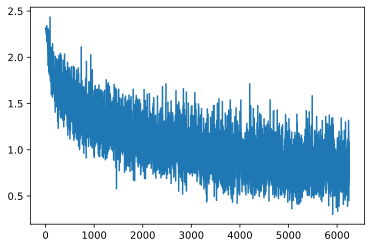

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(range(len(loss_history)), loss_history)
plt.show()

In retrospect, we could have probably added a batch normalization layer to stabilize and expedite training. However, since this post is largely meant as an introduction to PyTorch modeling, not model optimization or design, the example suffices.

# Evaluation

Now we have finally reached the last step of the development cycle: testing and evaluating the model. This last step will also require us to write a custom loop as we receive batches of data from the `test_loader` object we've created above. The good news, however, is that the testing loop is not going to look too much different from the training loop; the only difference will be that we will not be backpropagating per each iteration. We will also be using `model.eval()` to make sure that the model is in the evaluation mode, not its default training mode. This ensures that things like batch normalization and dropout work correctly.

Let's talk briefly about the details of this loop. Here, the metric we're collecting is accuracy. First, we generally see how many correct predictions the model generates. Then, we also see per-class accuracy; that is, whether our model is good at predicting any particular class. This ensures that the model's performance is balanced throughout all labels. 

In [15]:
num_correct = 0
num_samples = 0
num_class_correct = [0] * 10
num_class_samples = [0] * 10

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        num_samples += labels.size(0)
        num_correct += (preds == labels).sum().item()

        for pred, label in zip(preds, labels):
            num_class_samples[label] += 1
            num_class_correct[label] += int(label == pred)

acc = num_correct / num_samples * 100
print(f"Accuracy: {acc}%")

for i in range(10):
    class_acc = num_class_correct[i] / num_class_samples[i] * 100
    print(f"Accuracy of {classes[i]}: {class_acc}%")

Accuracy: 69.39%
Accuracy of plane: 75.6%
Accuracy of car: 81.3%
Accuracy of bird: 41.8%
Accuracy of cat: 62.6%
Accuracy of deer: 56.599999999999994%
Accuracy of dog: 63.9%
Accuracy of frog: 74.1%
Accuracy of horse: 75.8%
Accuracy of ship: 89.4%
Accuracy of truck: 72.8%


And here is the result! An overall accuracy of 70 percent is definitely not impressive, and we certainly could have done better by building a deeper model, or by using more complex architectures. However, this isn't the worst performance considering the fact that we only had three convolutional layers. The more important takeaway from this tutorial is how to prepare data, build models, and train and evaluate them through a custom loop. 

# Conclusion

From the tone and style of my writing, it is perhaps immediately clear to you that I am not officially a PyTorch fanboy. Yes, I will admit that I loved Keras for its simplicity, but after having spent more time learning python and DL, I now much prefer the freedom provided by PyTorch's reasonably abstract API. 

I hope this notebook provided you with a nice, simple introduction to PyTorch. In the coming notebooks, we will take a deeper dive into implementing models with PyTorch, starting from RNNs all the way up to classic SOTA vision models like InceptionNet, ResNet, and seq2seq models. I can definitely tell you that these are coming, because, as funny as this sounds, I already have all the notetbooks and code ready; I just have to annotate them. 

I hope you've enjoyed reading this post. Catch you up in the next one!